<a href="https://colab.research.google.com/github/GodRishUniverse/Deepfake-detect-AIC/blob/main/Learning/Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files

# Upload kaggle.json manually
files.upload()

{}

In [3]:
import os

# Move kaggle.json to the correct directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set permissions to prevent permission errors
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
!kaggle datasets list -s deepfake

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.11/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [6]:
!kaggle datasets download -d manjilkarki/deepfake-and-real-images

Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
 99% 1.67G/1.68G [00:21<00:00, 135MB/s]
100% 1.68G/1.68G [00:21<00:00, 84.6MB/s]


In [7]:
!unzip deepfake-and-real-images.zip -d deepfake-and-real-images.zip

Archive:  deepfake-and-real-images.zip
checkdir:  cannot create extraction directory: deepfake-and-real-images.zip
           File exists


In [8]:
!unzip deepfake-and-real-images.zip -d deepfake-and-real-images.zip

Archive:  deepfake-and-real-images.zip
checkdir:  cannot create extraction directory: deepfake-and-real-images.zip
           File exists


In [9]:
import shutil
import zipfile

# Remove existing folder if it exists
shutil.rmtree("deepfake-and-real-images", ignore_errors=True)

# Extract the ZIP file again
with zipfile.ZipFile("deepfake-and-real-images.zip", "r") as zip_ref:
    zip_ref.extractall("deepfake-and-real-images")

# Confirm extraction
import os
print(os.listdir("deepfake-and-real-images"))

['Dataset']


In [10]:
from pathlib import Path

In [11]:
data_path = Path('deepfake-and-real-images')
image_path = data_path / "Dataset"
train_path = image_path / "Train"
test_path = image_path / "Test"

In [12]:
import random
from PIL import Image
#set seed
#random.seed(42)

#Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

#pick a random image path
random_image_path = random.choice(image_path_list)

In [14]:
image_class = random_image_path.parent.stem

Random Image Path: deepfake-and-real-images/Dataset/Train/Real/real_53318.jpg
Image class: Real
Image Heigh: 256
Image Width: 256


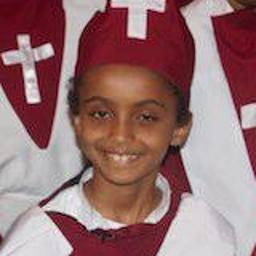

In [15]:
img = Image.open(random_image_path)
#print metadata
print(f'Random Image Path: {random_image_path}')
print(f"Image class: {image_class}")
print(f'Image Heigh: {img.height}')
print(f'Image Width: {img.width}')
img

In [16]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

(-0.5, 255.5, 255.5, -0.5)

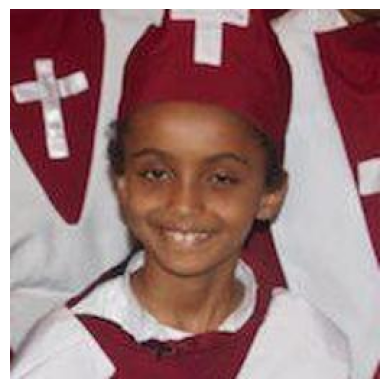

In [17]:
import numpy as np
import matplotlib.pyplot as plt
img_as_array = np.asarray(img)
plt.imshow(img)
plt.axis(False)

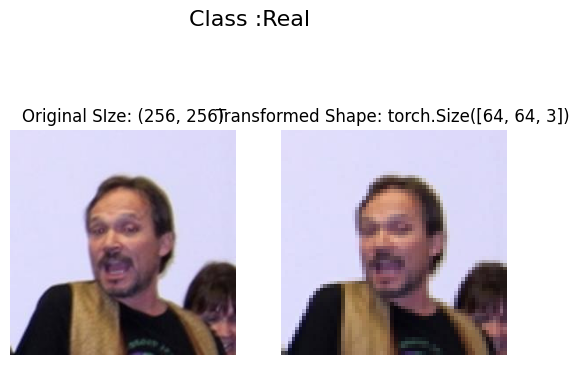

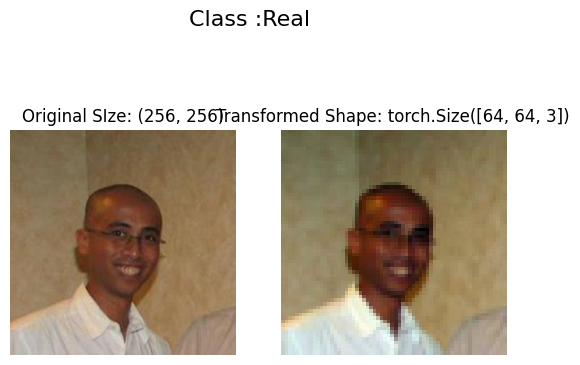

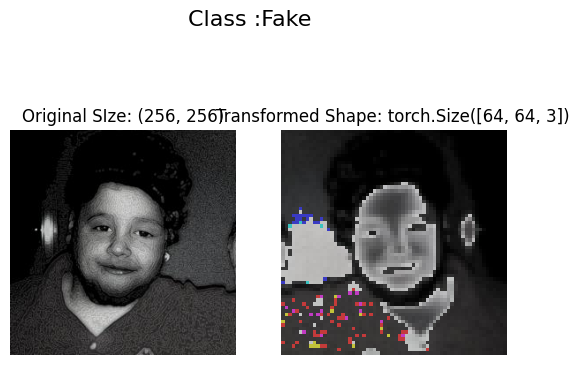

In [18]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
data_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(),
    transforms.ColorJitter(),
    transforms.ToTensor()
])
def plot_transformed_images(image_paths, transforms, n=3, seed = 42):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original SIze: {f.size}')
      ax[0].axis(False)

      transformed_image = transforms(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed Shape: {transformed_image.shape}')
      ax[1].axis(False)
      fig.suptitle(f'Class :{image_path.parent.stem}', fontsize = 16)
plot_transformed_images(image_path_list, data_transforms)

In [19]:
train_data = datasets.ImageFolder(root = train_path,
                                  transform= data_transforms,
                                  target_transform=None)
test_data = datasets.ImageFolder(root = test_path,
                                 transform = data_transforms)
classes = train_data.classes

In [20]:
train_dataloader = DataLoader(dataset=train_data, batch_size = 16, num_workers=1, shuffle = True) # Reduced batch size to 16
test_dataloader = DataLoader(dataset = test_data, batch_size = 16, num_workers=1, shuffle = False) # Reduced batch size to 16

In [31]:
class DeepfakeDetectionModel(nn.Module):
  def __init__(self, in_features, out_features, hidden_units):
    super().__init__()
    #We need multiple blocks for out data to pass through
    self.block1 = nn.Sequential(
        #First the convuloutional layer
        nn.Conv2d(in_channels=in_features,
                  out_channels = hidden_units,
                  kernel_size=3,
                  stride = 1,
                  padding=0),
        nn.BatchNorm2d(hidden_units),  # Add Batch Normalization
        ##ReLU layer
        nn.LeakyReLU(),
        #Maxpool Layer
        nn.MaxPool2d(kernel_size=2,
                     stride = 2))
    #Same block
    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride = 1,
                  padding = 0),
        nn.BatchNorm2d(hidden_units),  # Add Batch Normalization
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels = hidden_units,
                  kernel_size=3,
                  stride = 1,
                  padding = 0),
        nn.BatchNorm2d(hidden_units),  # Add Batch Normalization
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride = 2))

    self.dropout = nn.Dropout(0.4)  # Add dropout to prevent overfitting

    self.classifier = nn.Sequential(
        nn.Flatten(),
        # Calculate the correct input features dynamically
        nn.Linear(in_features = hidden_units * 13 * 13, out_features=out_features), #Updated this line to match the output of block2
        nn.LeakyReLU(),
        nn.Dropout(0.5),  # Add another dropout
        nn.Linear(out_features, out_features) #Updated to output_features so the shapes match
    )
  #Forward pass the data through the different layers, and return the final output of x
  def forward(self,x):
      x = self.block1(x)
      x = self.block2(x)
      x = self.dropout(x)
      x = self.classifier(x)
      return x

In [35]:
len(classes)

2

In [34]:
model = DeepfakeDetectionModel(in_features=3, out_features=1, hidden_units=10).to(device)

In [33]:
image_batch, label_batch = next(iter(train_dataloader)) #Create dummy data do find out what the value needs to be for the input shape of our linear layer

In [32]:
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [36]:
model(image_batch.to(device))

tensor([[-0.8314],
        [-1.0935],
        [-0.9827],
        [-0.7884],
        [-0.7871],
        [-0.7884],
        [-0.7884],
        [-0.7884],
        [-0.7884],
        [-0.7884],
        [-0.7871],
        [-0.7879],
        [-0.7854],
        [-0.7884],
        [-1.3368],
        [-0.7874],
        [-0.7884],
        [-1.0540],
        [-0.7884],
        [-0.7884],
        [-0.7884],
        [-0.7865],
        [-1.0340],
        [-0.7874],
        [-1.1837],
        [-0.9822],
        [-0.7870],
        [-0.7884],
        [-0.7884],
        [-0.8700],
        [-0.9979],
        [-0.7884]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [28]:
# Hyperparameters
LEARNING_RATE = 1e-2
BATCH_SIZE = 32
EPOCHS = 10
STEP_SIZE = 10
GAMMA = 0.1
WEIGHT_DECAY = 1e-5

In [37]:
from torch import nn
from torch import optim

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
# TODO  - change the scheduler accordingly
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = STEP_SIZE, gamma = GAMMA)

In [38]:
def train_one_step(model, dataloader, optimizer, scheduler, loss, device):
  model.train()
  total_loss = 0
  for image_batch, label_batch in dataloader:
    image_batch = image_batch.to(device)
    label_batch = label_batch.to(device)
    pred = model(image_batch)
    loss = loss_fn(pred, label_batch.unsqueeze(1).float())
    total_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
  return total_loss/len(dataloader)

In [39]:
def test(model, dataloader, loss_fn, device):
  model.eval()
  loss = 0
  for image_batch, label_batch in dataloader:
    image_batch = image_batch.to(device)
    label_batch = label_batch.to(device)
    pred = model(image_batch)
    loss += loss_fn(pred, label_batch.unsqueeze(1).float())
  return loss/len(dataloader)

In [40]:
%pip install tqdm

In [44]:
from tqdm.auto import tqdm
def train(model, train_dataloader, test_dataloader, optimizer, scheduler, loss_fn, epochs, device):
  for epoch in tqdm(range(epochs)):
    loss = train_one_step(model, train_dataloader, optimizer, scheduler, loss_fn, device)
    test_loss = test(model, test_dataloader, loss_fn, device)
    print(f"Epoch: [{epoch+1}/{epochs}] | Loss: {loss} | Test Loss: {test_loss}")

In [45]:
# TODO: add other metrics like accuracy, f1_score, etc.
train(model, train_dataloader, test_dataloader, optimizer, scheduler, loss_fn, EPOCHS, device)

  0%|          | 0/10 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 2230 has 14.74 GiB memory in use. Of the allocated memory 14.48 GiB is allocated by PyTorch, and 119.85 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)